In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

In [3]:
demographic = pd.read_csv("data/demographic.csv")
products = pd.read_csv("data/product.csv")
transactions = pd.read_csv("data/transaction_data.csv")

In [4]:
display(demographic.head())
display(products.head())
display(transactions.head())

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


## Feature engineering

Representing ages and incomes as ints.

In [5]:
def parse_datetime(transaction):
    """
    Takes a transaction row from the `transaction_data.csv` file, and uses `TRANS_TIME` and `DAY` columns to create a datetime object.
    """
    time = transaction["TRANS_TIME"]
    
    if len(time) == 1:
        time = '000'+ time
    elif len(time) == 2: #len being O(1) in python it's ok tu use it twice
        time = '00' + time
        
    return datetime.strptime(time, '%H%M') + timedelta(days=transaction["DAY"] - 1) # (-1 as the `DAY` column is 1 indexed)

In [6]:
transactions["TRANS_TIME"] = transactions["TRANS_TIME"].astype(str) # We need to cast transaction times to avoid automatic coercion by python.
transactions["DATETIME"] = transactions.apply(parse_datetime, axis=1)
display(transactions.head())

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,DATETIME
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1900-01-01 16:31:00
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1900-01-01 16:31:00
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1900-01-01 16:31:00


Merge transactions and demoraphic dataframes :

In [7]:
y = transactions.set_index('DATETIME').groupby(pd.Grouper(freq='D'))['SALES_VALUE'].sum()
X = y.index.to_frame()

def getValueWithLag(date, lag):
    """
    Find the sales value at a date that has the given lag with the given date.
    """
    lagged_datetime = date - timedelta(days=lag)
    if y.index.contains(lagged_datetime):
        return y[date - timedelta(days=1)]
    else:
        return float("nan")
    
X["MONTH"] = X["DATETIME"].apply(lambda date: date.month)
X["WEEK"] = X["DATETIME"].apply(lambda date: int(date.strftime("%V")))
X["WEEKDAY"] = X["DATETIME"].apply(lambda date: date.weekday())
X["DAY"] = range(1, y.count() + 1)
X["DAY"] = X["DAY"].map(lambda day: day % 365)
X["LAG_1_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 1))
X["LAG_2_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 2))
X["LAG_3_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 3))
X["LAG_7_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 7))
X["LAG_30_SALES"] = X["DATETIME"].apply(lambda date: getValueWithLag(date, 30))
X = X.iloc[30:] # Removing 7 first days as they have NaN values for lagged sales
y = y.iloc[30:] # Same for the mesured variable to have the corresponding sales vector
X = X.drop(["DATETIME"], axis=1) # Remove datetime as it is not numerical

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Splitting train and test set (80%/20%)
split = int(0.80*len(y))
y_train, y_test = y[:split], y[split:]
X_train, X_test = X.iloc[:split,:], X.iloc[split:,:]

tscv = TimeSeriesSplit(n_splits=10)
cv = tscv.split(X_train)

n_estimators = np.linspace(start = 200, stop = 2000, num = 20).astype(int).tolist()
max_features = ['auto', 'sqrt']
max_depth = np.linspace(5, 1005, num = 200).astype(int).tolist()
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv=cv, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.5min finished


{'n_estimators': 578,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 532,
 'bootstrap': True}

Search space of 144,720 models : too large, we will use a RandomizedSearch with cross-validation instead of the grid search.

Best parameters : {'n_estimators': 578,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 532,
 'bootstrap': True}

Time series split : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit
Cross validation : https://scikit-learn.org/stable/modules/cross_validation.html

Model Performance
Average Error: 1551.9936.
Accuracy = 92.1445%.
RMSE = 2393.3697.


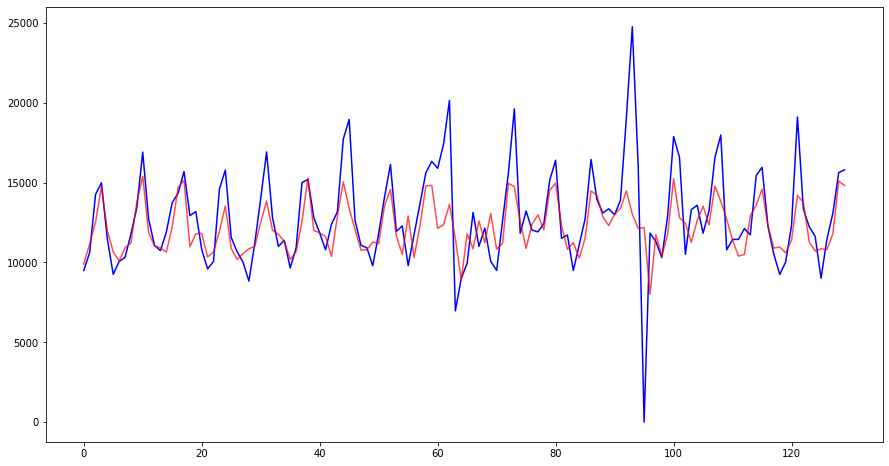

In [12]:
import math
from sklearn.metrics import mean_squared_error

def score(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.median((errors / y_test))
    accuracy = 100 - mape
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.4f}%.'.format(accuracy))
    print('RMSE = {:0.4f}.'.format(rmse))

score(rf_random, X_test, y_test)
rcParams["figure.figsize"] = (15,8)
plt.plot(y_test.values, 'b')
plt.plot(rf_random.predict(X_test), 'r', alpha = 0.7)
plt.show()

# features = X.columns
# importances = rf_random.feature_importances_
# indices = np.argsort(importances)
# plt.title('Features Importance')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

Problem with mean as the spike induces more error.